In [251]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [252]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.3.0


In [254]:
data = pd.read_csv('train_NIR5Yl1.csv').sample(frac=1)
print(data.describe())

features = data[['Reputation', 'Answers', 'Views', 'Tag']]
onehot_Tag = pd.get_dummies(features['Tag'])
features = features.drop(columns=['Tag'])
features = pd.concat([features, onehot_Tag], axis=1)
targets = data['Upvotes']

data_preprocessed = pd.concat([features, targets], axis=1)


                  ID    Reputation  ...         Views        Upvotes
count  330045.000000  3.300450e+05  ...  3.300450e+05  330045.000000
mean   235748.682789  7.773147e+03  ...  2.964507e+04     337.505358
std    136039.418471  2.706141e+04  ...  8.095646e+04    3592.441135
min         1.000000  0.000000e+00  ...  9.000000e+00       0.000000
25%    117909.000000  2.820000e+02  ...  2.594000e+03       8.000000
50%    235699.000000  1.236000e+03  ...  8.954000e+03      28.000000
75%    353620.000000  5.118000e+03  ...  2.687000e+04     107.000000
max    471493.000000  1.042428e+06  ...  5.231058e+06  615278.000000

[8 rows x 6 columns]


In [255]:
train_dataset = data_preprocessed

#train_dataset = data_preprocessed.sample(frac=0.8, random_state=0)
#test_dataset = data_preprocessed.drop(train_dataset.index)

train_features = train_dataset.copy()
#test_features = test_dataset.copy()

train_labels = train_features.pop('Upvotes')
#test_labels = test_features.pop('Upvotes')
print(train_features)
print(train_labels)
#train_dataset.describe().transpose()[['mean', 'std']]

        Reputation  Answers     Views  a  c  h  i  j  o  p  r  s  x
325640       157.0      2.0    4763.0  1  0  0  0  0  0  0  0  0  0
39997      31280.0      4.0    7967.0  0  1  0  0  0  0  0  0  0  0
23123       1798.0      2.0  379348.0  0  0  1  0  0  0  0  0  0  0
260028       446.0      4.0    7959.0  1  0  0  0  0  0  0  0  0  0
218514     89433.0      2.0    1844.0  0  0  0  0  0  0  1  0  0  0
...            ...      ...       ... .. .. .. .. .. .. .. .. .. ..
294907      2062.0      5.0   12219.0  0  0  0  0  0  0  1  0  0  0
260316      1007.0      3.0   12844.0  0  1  0  0  0  0  0  0  0  0
299142      1881.0      9.0   18274.0  0  0  0  1  0  0  0  0  0  0
235483       618.0      1.0   28789.0  0  0  0  0  1  0  0  0  0  0
208090     16394.0      4.0   40839.0  1  0  0  0  0  0  0  0  0  0

[330045 rows x 13 columns]
325640     15.0
39997     340.0
23123     339.0
260028     19.0
218514    279.0
          ...  
294907     49.0
260316     13.0
299142     73.0
235483     3

In [256]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
#print(normalizer.mean.numpy())

In [257]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.1),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.1),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.1),   
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.1),   
      layers.Dense(1),
  ])
  rmse = tf.keras.metrics.RootMeanSquaredError()
  model.compile(loss=tf.keras.losses.MSE,
                optimizer=tf.keras.optimizers.Adam(0.0004),
                metrics=[
                  #  tf.keras.metrics.MAE,
                  #  tf.keras.metrics.MSE,
                    #R_squared, # -1 and 1, < 0 => useless, 0 and 1 => better close to 1
                   rmse,
                ]
                )
  return model

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, mode='auto',restore_best_weights=True)


In [258]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_14 (Normalizat (None, 13)                27        
_________________________________________________________________
dense_73 (Dense)             (None, 128)               1792      
_________________________________________________________________
dropout_47 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_48 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_49 (Dropout)         (None, 128)             

In [259]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=2, epochs=100, callbacks=[callback])

Epoch 1/100
8252/8252 - 16s - loss: 9725771.0000 - root_mean_squared_error: 3118.6169 - val_loss: 3613929.2500 - val_root_mean_squared_error: 1901.0337
Epoch 2/100
8252/8252 - 16s - loss: 5552341.0000 - root_mean_squared_error: 2356.3406 - val_loss: 2903143.5000 - val_root_mean_squared_error: 1703.8613
Epoch 3/100
8252/8252 - 16s - loss: 4335469.0000 - root_mean_squared_error: 2082.1790 - val_loss: 1733284.3750 - val_root_mean_squared_error: 1316.5426
Epoch 4/100
8252/8252 - 16s - loss: 3909615.7500 - root_mean_squared_error: 1977.2748 - val_loss: 1798240.8750 - val_root_mean_squared_error: 1340.9850
Epoch 5/100
8252/8252 - 16s - loss: 3334712.2500 - root_mean_squared_error: 1826.1195 - val_loss: 1569629.2500 - val_root_mean_squared_error: 1252.8485
Epoch 6/100
8252/8252 - 16s - loss: 2930370.7500 - root_mean_squared_error: 1711.8325 - val_loss: 1739016.3750 - val_root_mean_squared_error: 1318.7177
Epoch 7/100
8252/8252 - 16s - loss: 2738199.7500 - root_mean_squared_error: 1654.7506 - 

In [260]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
 # plt.ylim([10, 80])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

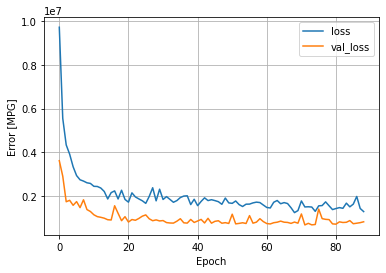

In [261]:
plot_loss(history)

In [262]:
data1 = pd.read_csv('test_8i3B3FC.csv').sample(frac=1)
data1.describe()

,ID,Reputation,Answers,Username,Views
count,141448.000000,1.414480e+05,141448.000000,141448.000000,1.414480e+05
mean,235743.073497,7.920927e+03,3.914873,81348.231117,2.984633e+04
std,136269.867118,2.791072e+04,3.577460,49046.098215,8.034374e+04
min,7.000000,0.000000e+00,0.000000,4.000000,9.000000e+00
25%,117797.000000,2.860000e+02,2.000000,40222.750000,2.608000e+03
50%,235830.000000,1.245000e+03,3.000000,78795.500000,8.977000e+03
75%,353616.000000,5.123000e+03,5.000000,122149.000000,2.698925e+04
max,471488.000000,1.042428e+06,73.000000,175737.000000,5.004669e+06


In [263]:
features = data1[['Reputation', 'Answers', 'Views', 'Tag']]
onehot_Tag = pd.get_dummies(features['Tag'])
features = features.drop(columns=['Tag'])
features = pd.concat([features, onehot_Tag], axis=1)


data_preprocessed = features

In [264]:
test_dataset = data_preprocessed

#train_dataset = data_preprocessed.sample(frac=0.8, random_state=0)
#test_dataset = data_preprocessed.drop(train_dataset.index)

test_features = test_dataset.copy()
#test_features = test_dataset.copy()


#test_labels = test_features.pop('Upvotes')


In [265]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


In [266]:
reloaded = tf.keras.models.load_model('dnn_model')
temp = reloaded.predict(test_features)


In [268]:
test_features = data1[['ID']]
temp[temp<0]=0
test_features['Upvotes'] = temp

print(test_features)
sort = test_features.sort_values(by=['ID'])
print(sort)

            ID      Upvotes
23906   385342    54.065750
139359  239724   204.771133
13799   172340    17.621380
76501   123582    18.537136
65989   328442   148.288269
...        ...          ...
8698    191088    35.407944
108826   60194    41.320168
135801  386997  2818.090820
24127   411715    22.215443
38379   197225   269.320099

[141448 rows x 2 columns]
            ID       Upvotes
118045       7    718.456055
74256        9     44.066330
132030      12     90.823128
47484       13    339.671082
20847       16     93.047401
...        ...           ...
32318   471473     14.681558
117596  471481    174.812195
94788   471486  10898.365234
84958   471487     62.274853
56426   471488     38.170242

[141448 rows x 2 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [269]:
sort.to_csv('Sub-8.csv', index=False)